#  Прогнозирование заказов такси

Имеем исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.


1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<b><font size=5>Что предстоить сделать в данном проекте:</font></b><a name="to_content."></a>

1. [Загрузить данные и подготовить их](#1.)
2. [Проанализировать данные.](#2.)
3. [Обучите разные модели с различными гиперпараметрами.](#3.)
4. [Проверить данные на тестовой выборке и сделать выводы.](#4.)

<b><font size=5>Описание данных</font></b>

1. *num_orders* - количество заказов 
2. *datetime* - время заказа

<b><font size=5>Подготовка данных</font></b><a name="1."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

Загрузим данные и сразу ознакомимся с ними. При открытии файла сразу приведём данные к удобному формату, чтобы потом было удобнее работать с временными рядами.

In [2]:
df = pd.read_csv(***, index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Видим, что данные выгружены с интервалом в 10 минут. Проверим соблюдён ли хронологический порядок

In [5]:
df.index.is_monotonic

True

Посмотрим за какой период нам представлены данные.

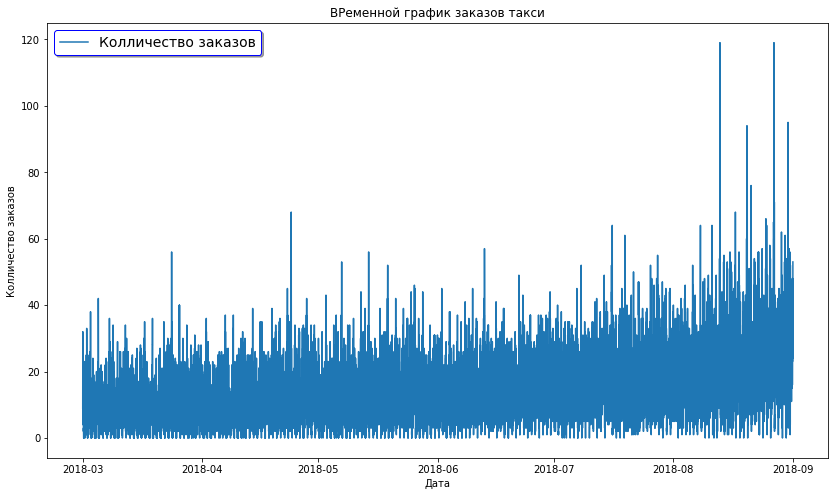

In [6]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=df)
plt.xlabel('Дата')
plt.ylabel('Колличество заказов')
plt.title('ВРеменной график заказов такси')
plt.legend(['Колличество заказов'], fontsize=14, shadow=True, facecolor='w', edgecolor='b')

Итак, видим, что у нас представлены данные за период с марта 2018 года по сентябрь 2018 года. Произведём ресемплирование по за час и посмотрим на изменения, а так же на скользящее среднее.

<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка и первичный осмотр данных проведены хорошо. Радует, что сам ряд был визуализирован.
</div>

In [7]:
data, df = df.resample('1H').sum(), df.resample('1H').sum()
data['rolling_mean'] = data.rolling(15).mean()

<div class="alert alert-block alert-success">
<b>Успех:</b> Ресемплинг был сделан корректно.
</div>

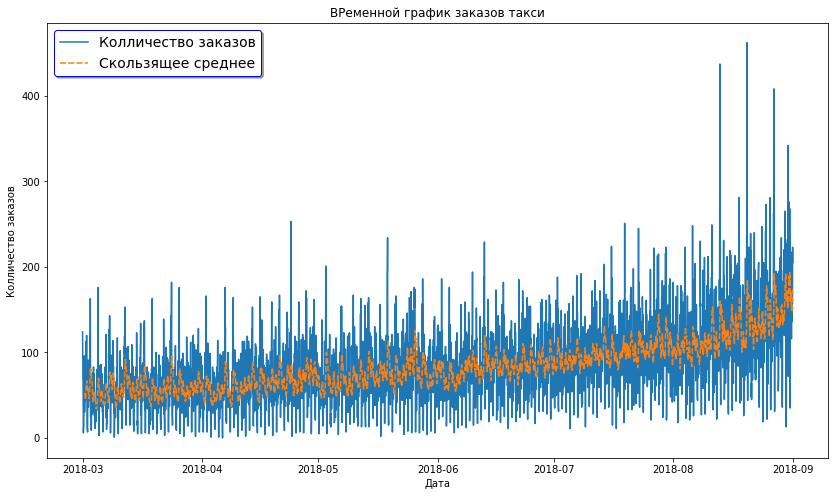

In [8]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=data)
plt.xlabel('Дата')
plt.ylabel('Колличество заказов')
plt.title('ВРеменной график заказов такси')
plt.legend(['Колличество заказов', 'Скользящее среднее'], fontsize=14, shadow=True, facecolor='w', edgecolor='b')

Видим, что график стал более плотнее и понятнее. переходим к анализу данных

<b><font size=5>Анализ данных</font></b><a name="2."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

In [9]:
decomposed = seasonal_decompose(df) 

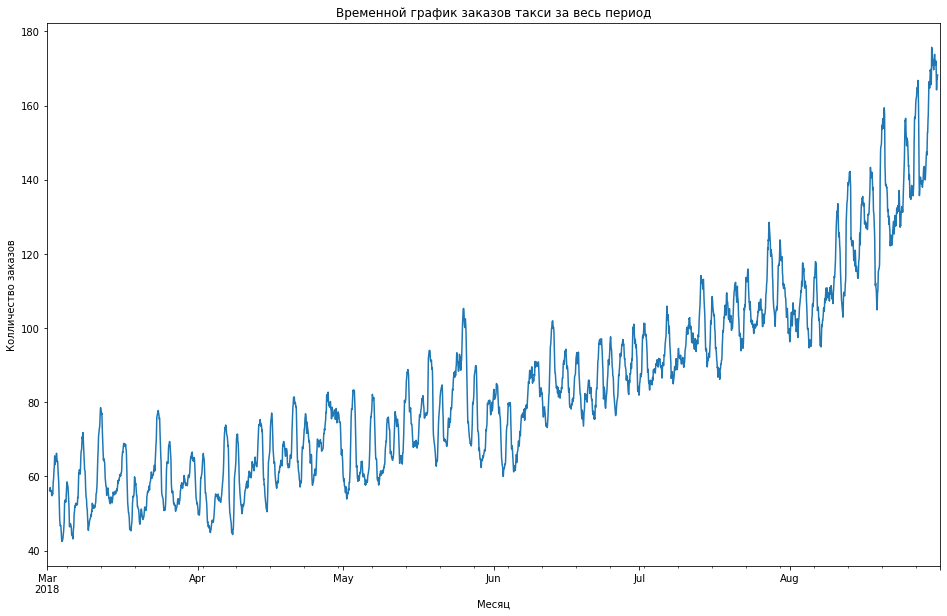

In [10]:
plt.rcParams.update({'figure.figsize': (16,10)})
decomposed.trend.plot()
plt.xlabel('Месяц')
plt.ylabel('Колличество заказов')
plt.title('Временной график заказов такси за весь период')
plt.show()

Посмотрев на этот график можно сказать, что начиная с весны колличество заказов ежемесячно увеличивается. Посмотрим на недельные колебания.

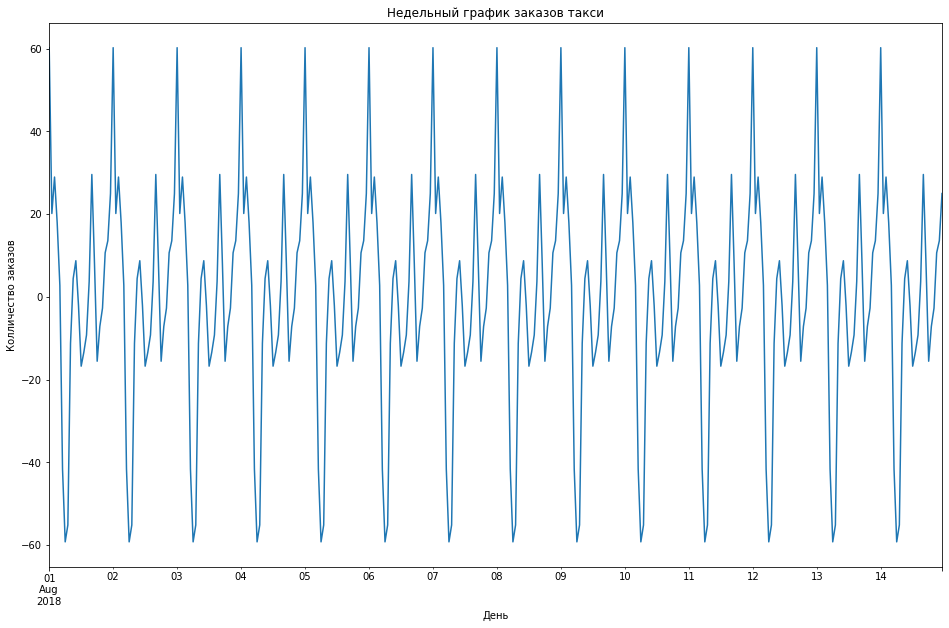

In [11]:
fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize': (16,10)})
decomposed.seasonal['2018-08-01':'2018-08-14'].plot()
plt.xlabel('День')
plt.ylabel('Колличество заказов')
plt.title('Недельный график заказов такси')
plt.show()

Видим, что в течение дня колличество заказов колеблется. Посмотрим поближе на дневную сезонность.

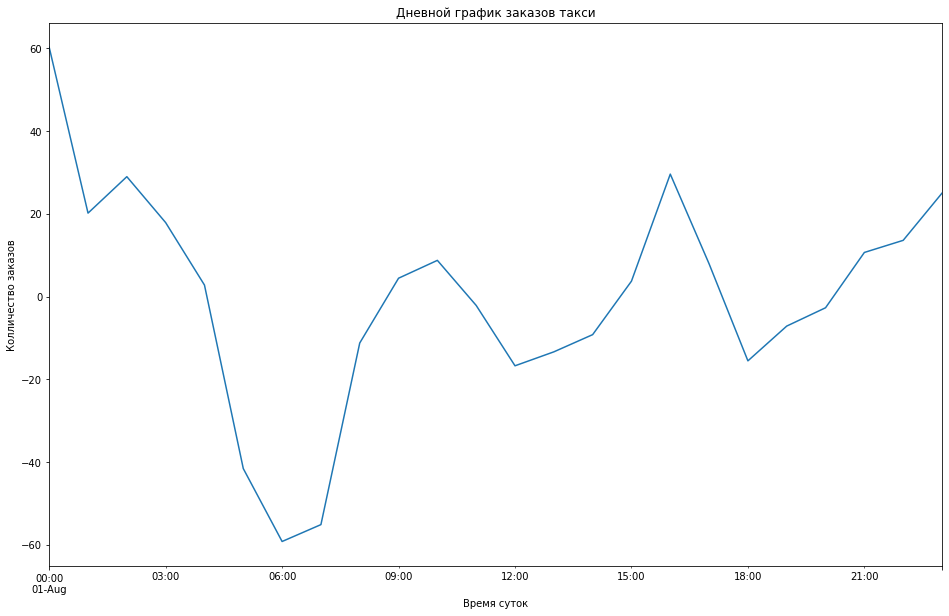

In [12]:
plt.rcParams.update({'figure.figsize': (16,10)})
decomposed.seasonal['2018-08-01':'2018-08-01'].plot()
plt.xlabel('Время суток')
plt.ylabel('Колличество заказов')
plt.title('Дневной график заказов такси')
plt.show()

Исходя из этого графика можно увидеть, что спад заказов идёт с 3 утра и набирает где-то в районе 7:00, а прик приходится на вечернее/ночное время суток. Перейдём к обучению моделей.

<b><font size=5>Обучение моделей</font></b><a name="3."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

В предудущем пункте мы увидели, что на графиках присутствукт дневная сезонность и месячная сезонность.
Создадим новые признаки:
- за день
- за месяц
- за день недели
- за неделю

In [13]:
def make_features(data, max_lag, rolling_mean_size):

    data['month'] = data.index.month
    data['week'] = data.index.week
    data['day_of_week'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    return data

In [14]:
new_data = make_features(df, 60, 10)

In [15]:
new_data.head(10)

,num_orders,month,week,day_of_week,day,hour,lag_1,lag_2,lag_3,lag_4,...,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 12:00:00,32,3,9,5,3,12,57.0,52.0,73.0,56.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,41.2
2018-03-03 13:00:00,28,3,9,5,3,13,32.0,57.0,52.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,41.9
2018-03-03 14:00:00,41,3,9,5,3,14,28.0,32.0,57.0,52.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,38.3
2018-03-03 15:00:00,76,3,9,5,3,15,41.0,28.0,32.0,57.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,38.0
2018-03-03 16:00:00,46,3,9,5,3,16,76.0,41.0,28.0,32.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,44.1
2018-03-03 17:00:00,49,3,9,5,3,17,46.0,76.0,41.0,28.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,47.8
2018-03-03 18:00:00,68,3,9,5,3,18,49.0,46.0,76.0,41.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,51.0
2018-03-03 19:00:00,30,3,9,5,3,19,68.0,49.0,46.0,76.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,52.2
2018-03-03 20:00:00,83,3,9,5,3,20,30.0,68.0,49.0,46.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,47.9


Напишем метрику RMSE

In [16]:
def RMSE(target_test, predict):
    return np.sqrt(mean_squared_error(target_test, predict))

In [17]:
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Разобьём наши данные на тестовую и обучающую выборки.

In [18]:
features_train, features_test, target_train, target_test = train_test_split(
    new_data.drop(['num_orders'], axis=1), new_data['num_orders'], test_size=0.1, random_state=42, shuffle=False)

Посмотрим как разбились наши данные.

Выборка до разделения: 4356
Обучающая выборка: 3920
Тестовая выборка: 436


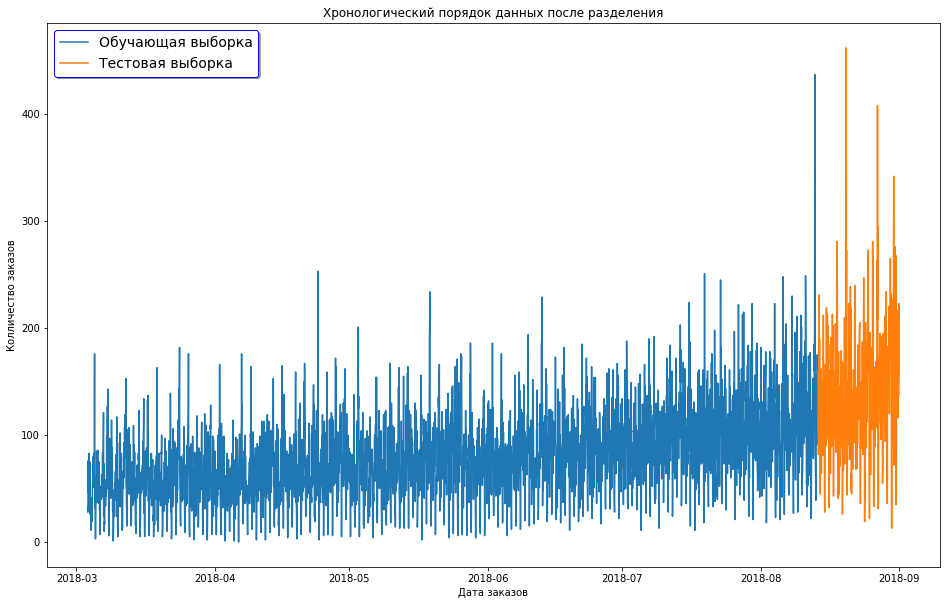

In [19]:
print('Выборка до разделения: %d' % (len(new_data)))
print('Обучающая выборка: %d' % (len(target_train)))
print('Тестовая выборка: %d' % (len(target_test)))
plt.plot(target_train)
plt.plot(target_test)
plt.legend(['Обучающая выборка', 'Тестовая выборка'], fontsize=14, shadow=True, facecolor='w', edgecolor='b')
plt.xlabel('Дата заказов')
plt.ylabel('Колличество заказов')
plt.title('Хронологический порядок данных после разделения')
plt.show()

Данные разбиты правильно. Напишем параметры для наших моделей и приступим к обучению.

In [20]:
LGBMRegressor_model = LGBMRegressor()
LGBM_parametrs = {
    'n_estimators': range(1, 100, 10),
    'max_depth': range(1, 20),
}

In [21]:
tscv = TimeSeriesSplit()
grid_LGBM = GridSearchCV(LGBMRegressor_model, param_grid = LGBM_parametrs, cv=tscv,
    scoring = RMSE_score, n_jobs=-1, verbose=3)

In [22]:
grid_LGBM.fit(features_train, target_train)

Fitting 5 folds for each of 190 candidates, totalling 950 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 20),
                         'n_estimators': range(1, 100, 10)},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=3)

In [23]:
grid_LGBM.best_score_

-23.996425234669104

In [24]:
catboost_model = CatBoostRegressor(random_state=42,silent=True)

catboost_params = {
    'iterations': [100],
    'max_depth': [5,10]
}

In [25]:
tscv = TimeSeriesSplit()
grid_cat = GridSearchCV(catboost_model, param_grid = catboost_params, cv=tscv,
    scoring = RMSE_score, n_jobs=-1, verbose=3)

In [26]:
grid_cat.fit(features_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000021BD498C820>,
             n_jobs=-1, param_grid={'iterations': [100], 'max_depth': [5, 10]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=3)

In [27]:
grid_cat.best_score_

-24.422162583385337

In [28]:
constant_model = DummyRegressor(strategy='mean')

In [29]:
constant_model.fit(features_train,target_train)
constant_pred = constant_model.predict(features_test)
RMSE(target_test,constant_pred)

84.78402117466065

Итак, после обучения наилучшую оценку показала модель LGBM. Протестируем её и сравним результат

<b><font size=5>Тестирование модели</font></b><a name="4."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

In [30]:
pred = grid_LGBM.predict(features_test)

In [32]:
RMSE(target_test, pred)

40.222072288802096

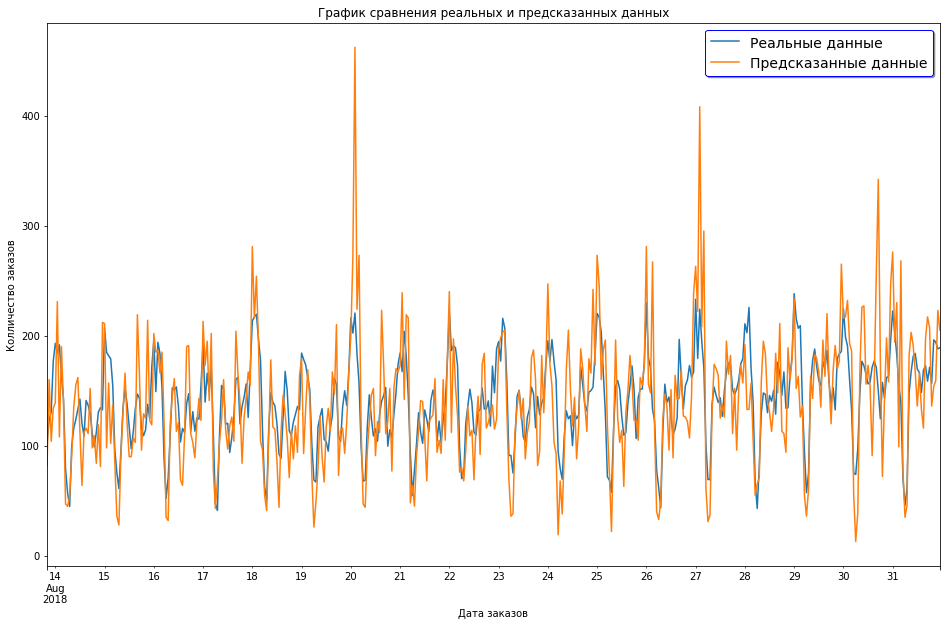

In [33]:
predictions = pd.DataFrame(pred)
predictions.index = target_test.index
predictions.plot()
target_test.plot()
plt.xlabel('Дата заказов')
plt.ylabel('Колличество заказов')
plt.legend(['Реальные данные', 'Предсказанные данные'], fontsize=14, shadow=True, facecolor='w', edgecolor='b')
plt.title('График сравнения реальных и предсказанных данных')
plt.show()

<b><font size=4>Вывод</font></b>
[<font size="2">(к содержанию)</font>](#to_content.)

Итак, судя по графику наша модель почти правильно предсказывала время пиковой загрузки. В тренды мы попали, так что сможем прогнозировать верно в период пиковой нагрузки, чтобы привлекать больше водителей.  Оценка RMSE ниже 48. Цель достигнута